In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import xgboost as xgb


sns.set(style='white', context='notebook', palette='deep')

plt.rcParams['figure.figsize'] = (10, 6)

           
train = pd.read_csv("./csv/train.csv")[:600]
test = pd.read_csv("./csv/train.csv")[600:]



In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
def detect_outliers(df, feat, n):
    outlier_list = []
    
    for col in feat:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
         
        outlier_list.extend(outlier_list_col)
        
    outlier_list = Counter(outlier_list)        
    multiple_out = list( k for k, v in outlier_list.items() if v > n )
    return multiple_out

Outliers_to_drop = detect_outliers(train, ["PassengerId", "Fare", "Parch", "SibSp"], 2)
train.loc[Outliers_to_drop]
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

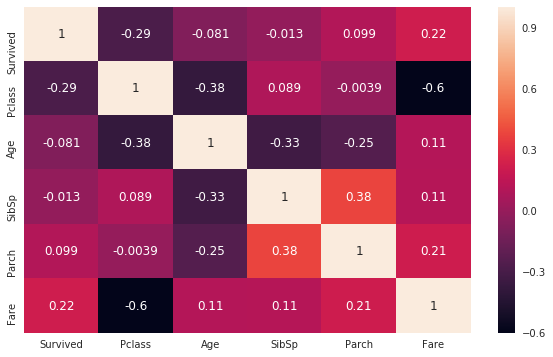

In [31]:
sns.heatmap(train[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]].corr(), annot=True)

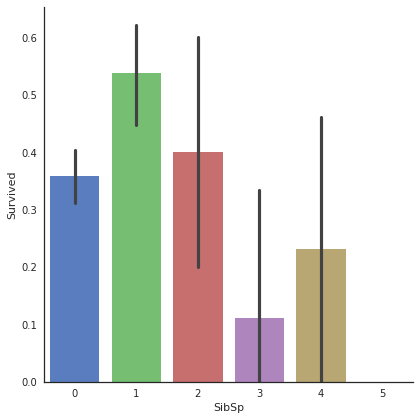

In [35]:
sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")

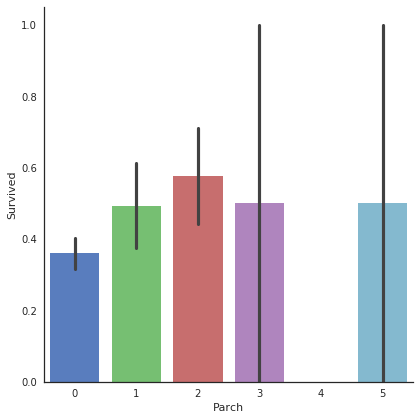

In [36]:
sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")

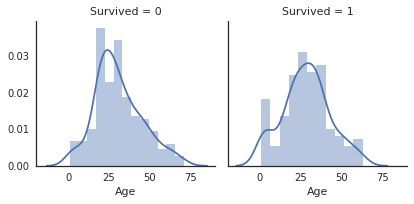

In [38]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

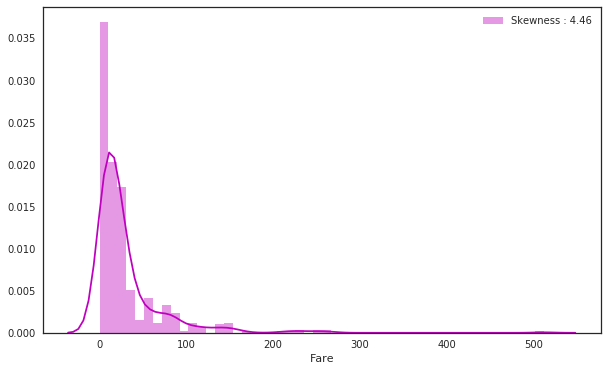

In [40]:
g = sns.distplot(train["Fare"], color="m", label="Skewness : %.2f"%(train["Fare"].skew()))
g = g.legend(loc="best")


In [4]:
train = train.drop(['PassengerId','Name','Ticket'], axis=1)
test = test.drop(['PassengerId','Name','Ticket'], axis=1)

train["Embarked"] = train["Embarked"].fillna("S")
train["Age"] = train["Age"].fillna(train["Age"].median())

train.loc[train["Sex"] == "female", "Sex"] = 0
train.loc[train["Sex"] != 0, "Sex"] = 1

train["Fare"] = train["Fare"].fillna(train["Fare"].median())

train.loc[train["Embarked"] == "S", "Embarked"] = 0
train.loc[train["Embarked"] == "C", "Embarked"] = 1
train.loc[train["Embarked"] == "Q", "Embarked"] = 2

test["Embarked"] = test["Embarked"].fillna("S")
test["Age"] = test["Age"].fillna(test["Age"].median())

test.loc[test["Sex"] == "female", "Sex"] = 0
test.loc[test["Sex"] != 0, "Sex"] = 1

test["Fare"] = test["Fare"].fillna(test["Fare"].median())

test.loc[test["Embarked"] == "S", "Embarked"] = 0
test.loc[test["Embarked"] == "C", "Embarked"] = 1
test.loc[test["Embarked"] == "Q", "Embarked"] = 2

In [5]:
#print(train.describe)
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'colsample_bytree': [0.7, 0.8, 0.9]}
ind_params = {'learning_rate':0.12, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8,
             'objective': 'binary:logistic'}

#forest = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)

forest = RandomForestClassifier(max_depth = 10, min_samples_split=8, n_estimators = 1000, random_state = 2)
model = forest.fit(train[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch"]].values, train["Survived"].values)
print(model.score(test[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch"]].values, test["Survived"].values))
#print(model.best_estimator_)
#print(model.best_score_)
#, "Age", "Sex", "Fare", "SibSp", "Parch", "Embarked"
#, "Age", "Sex", "Fare", "SibSp", "Parch", "Embarked"
#my_prediction = forest.predict(test[["Pclass", "Age", "Sex", "Fare", "SibSp", "Parch"]].values)


#PassengerId =np.array(test["PassengerId"]).astype(int)
#my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])
#print(my_solution)


#print(my_solution.shape)


0.845360824742268
